In [1]:
from torchtext import data
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import torch




8

In [286]:

# this needs to be cleaned up and data can be grouped in a more efficient way 

path= '/Users/tancredicp/Desktop/sailing_app/data/ML Training Resources/'
all_files = glob.glob(path + "/*.csv")

TAGS = data.Field(unk_token = None)
TAGS.build_vocab(['0','S', 'C','G','T','B','D', 'A'])

Data = []
for filename in all_files:
    temporary_dict = {}

    dfSpecific = pd.read_csv(filename, index_col=None, header=0)
    dfSpecific.fillna(0, inplace= True)
    
    dfSpecificY = dfSpecific['tag']
    Yarray = TAGS.numericalize((np.array(dfSpecificY)))
    
    #change to fixed number
    ynval =  9 #np.max(np.array(Yarray)) + 1
    Yarray = np.eye(ynval)[Yarray[0]]
    Yarray = torch.tensor(Yarray).unsqueeze(0)
    
    
    
    temporary_dict['tags'] = Yarray
    

    dfSpecificX = dfSpecific.drop(columns=['tag', 'tag_name', 'boat_class', 'time'])
    
    scaler = StandardScaler()
    columnsBeingStandardize = ['lat', 'lon', 'sog', 'heel', 'clew_load','pitch']
    dfSpecificX[columnsBeingStandardize] = scaler.fit_transform(dfSpecificX[columnsBeingStandardize])
    
    
    array1 = np.array(dfSpecificX[['lat', 'lon', 'sog', 'cog']])
    
    temp = torch.from_numpy(array1)
    
    temporary_dict['track'] = temp.unsqueeze(0)
    
    Data.append(temporary_dict)
    del(temporary_dict)


In [145]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.lstm1 = nn.GRU(batch_first= True, input_size = 4, hidden_size = 8, bidirectional= True, dropout = 0.9)
        self.fcn1 = nn.Linear(16, 9)
#         self.fcn2 = nn.Linear(512, 512)
#         self.fcn3 = nn.Linear(512, 9)
        
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):

        x, _ = self.lstm1(x)


        x = F.relu(self.fcn1(x))
#         x = F.dropout(x, p = 0.5)
#         x = F.relu(self.fcn2(x))
#         x = F.dropout(x, p = 0.5)
#         x = F.relu(self.fcn3(x))
#         x = F.dropout(x, p = 0.9)
#         x =x.squeeze(1)
  
        
        x = self.softmax(x)
        
        return x


In [146]:
import torch.optim as optim

net = Net()



In [147]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [148]:
len(Data)

24

In [149]:
X = Data[0]['track'].float()
y = Data[0]['tags'].float()

In [150]:
X.type(), y.type(), X.shape, y.shape

('torch.FloatTensor',
 'torch.FloatTensor',
 torch.Size([1, 3594, 4]),
 torch.Size([1, 3594, 9]))

In [ ]:
for epoch in range(10000):
    
    optimizer.zero_grad()
    
    running_loss = 0.0
    
    for i in Data:
#         print('a')
        X = i['track'].float()
        y = i['tags'].float()
        
        o2 = y.argmax(2).flatten()
#         print(Counter(np.array(o2)))
        
        outputs = net(X)
        
#         print(outputs.shape, y.shape)

        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    
    
    if epoch % 1== 0: 
        
        ##THIS IS WRONG - the score will only be for last race 
        
        o1 = (outputs.detach().argmax(2).flatten())
        o2 = y.argmax(2).flatten()
        acc = accuracy_score(o1, o2)
        print("Epoch: ", epoch, "Loss: ", running_loss, "Accuracy:", acc) 

Epoch:  0 Loss:  1.1121627110987902 Accuracy: 0.8353044240035041
Epoch:  1 Loss:  1.1140627544373274 Accuracy: 0.835742444152431
Epoch:  2 Loss:  1.0872251652181149 Accuracy: 0.8331143232588699
Epoch:  3 Loss:  1.056932371109724 Accuracy: 0.8309242225142357
Epoch:  4 Loss:  1.0907746907323599 Accuracy: 0.8186596583442839
Epoch:  5 Loss:  1.370995182543993 Accuracy: 0.8234778799824792


In [ ]:
from collections import Counter

In [289]:
Counter(np.array(o1))

Counter({4: 527, 7: 1756})

Counter({7: 2142, 4: 1452})
Counter({7: 1901, 4: 1040})
Counter({7: 1812, 4: 984})
Counter({4: 270, 7: 258})
Counter({4: 531, 7: 445})
Counter({4: 7100, 7: 4635, 1: 103})
Counter({7: 4092, 4: 2988, 1: 4})
Counter({7: 3168, 4: 2511})
Counter({7: 2542, 4: 961, 1: 5})
Counter({7: 4092, 4: 2988, 1: 4})
Counter({7: 1720, 4: 563})
Counter({4: 1491, 7: 996, 1: 11})
Counter({7: 1757, 4: 758})
Counter({7: 1261, 4: 1160})
Counter({7: 1837, 4: 1313})
Counter({7: 1896, 4: 864, 1: 10})
Counter({7: 1992, 4: 1162})
Counter({7: 2075, 4: 1095})
Counter({7: 1957, 4: 992})
Counter({7: 2078, 4: 1264})
Counter({7: 1939, 4: 1047})
Counter({7: 2186, 4: 1223})
Counter({7: 2387, 4: 973})
Counter({7: 1754, 4: 529})


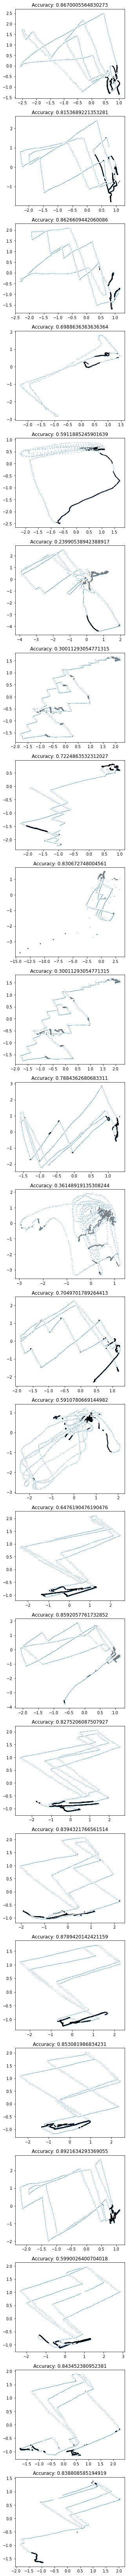

In [292]:
fig, axes = plt.subplots(24, 1, figsize = (5,120))
for i, ax  in zip(Data, axes):
    X = i['track'].float()
    y = i['tags'].float()
    outputs = net(X)
    o1 = (outputs.detach().argmax(2).flatten())
    print(Counter(np.array(o1)))
    o2 = y.argmax(2).flatten()
    acc = accuracy_score(o1, o2)
    
#     print("accuracy",  acc)
    
    lon = i['track'][0][:, 0]
    lat = i['track'][0][:, 1]
    cols = np.array(o1 == o2).astype(int)
    
    ax.scatter(np.array(lon), np.array(lat), s = 1)
    ax.scatter(np.array(lon), np.array(lat), c = o1, s = 1)
    ax.set_title("Accuracy: " + str(acc))


In [215]:
X.shape

torch.Size([1, 3594, 4])

In [216]:
o1.shape

torch.Size([3594])

In [164]:
#colors part of track labeled incorrectly when
#takes DF with lon and lat columns, preds series, true series
def quick_check(track, preds, trues):
    fig, axes = plt.subplots()
    matches = trues.eq(preds)
    track['matches'] = matches

    groups = track.groupby('matches')
    print('Percent Correct: ' + str(100*len(groups.get_group(True))/len(track)))
    for name, group in groups:
        axes.plot(group.lat, group.lon,marker='o', linestyle='', ms=2, label=name)
    axes.set_title(f"{track['place'].any()}, {track['track_id'].any()}")
    axes.legend()

array([1, 1, 1, ..., 1, 1, 1])

In [208]:
cols = np.array(o1 == o2).astype(int)

In [210]:
cols.shape

(3594,)

In [222]:
lon.shape, lat.shape, cols.shape

(torch.Size([3594]), torch.Size([3594]), (3594,))

In [241]:
cols = cols.astype(float) / 2 + 0.5

In [242]:
lon = Data[0]['track'][0][:, 0]
lat = Data[0]['track'][0][:, 1]



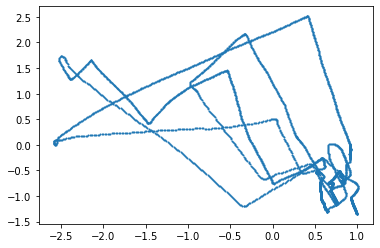

In [250]:
fig, axes = plt.subplots()
axes.scatter(np.array(lon), np.array(lat), s = 1)

In [247]:
cols

array([0.8, 0.8, 0.8, ..., 0.8, 0.8, 0.8])

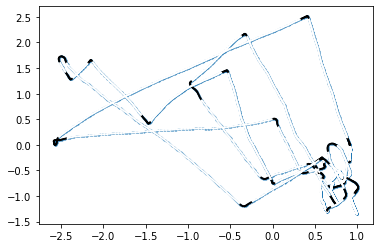

In [253]:
fig, axes = plt.subplots()
axes.scatter(np.array(lon), np.array(lat), s = 1)
axes.scatter(np.array(lon), np.array(lat), c = cols, s = 1)

In [178]:
import matplotlib.pyplot as plt

In [181]:
lon

tensor([1.0801, 1.1136, 1.0522,  ..., 0.8140, 0.8146, 0.8147],
       dtype=torch.float64)

In [182]:
lat

tensor([1.0801, 1.1136, 1.0522,  ..., 0.8140, 0.8146, 0.8147],
       dtype=torch.float64)

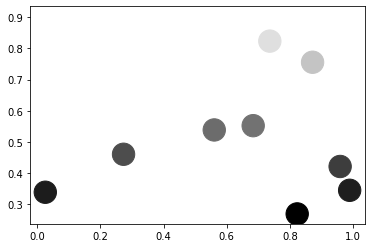

In [202]:
x = np.random.random(10)
y = np.random.random(10)

# Plot...
plt.scatter(x, y, c=y, s=500)
plt.gray()

plt.show()

In [203]:
y

array([0.82321875, 0.5387458 , 0.90289137, 0.26981882, 0.34546291,
       0.42173787, 0.33924022, 0.55240693, 0.46085665, 0.75557324])

In [234]:
cols, lon , lat

(array([0.6, 0.6, 0.6, ..., 0.6, 0.6, 0.6]),
 tensor([0.5169, 0.5262, 0.5362,  ..., 0.9956, 0.9956, 0.9958],
        dtype=torch.float64),
 tensor([-0.5162, -0.5372, -0.5570,  ..., -1.3453, -1.3475, -1.3498],
        dtype=torch.float64))

In [236]:
x, y

(array([0.73620664, 0.56033028, 0.9401928 , 0.82282067, 0.98887003,
        0.95874259, 0.02562144, 0.68354313, 0.27327972, 0.87153018]),
 tensor([[[0., 0., 0.,  ..., 0., 1., 0.],
          [0., 0., 0.,  ..., 0., 1., 0.],
          [0., 0., 0.,  ..., 0., 1., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))